# QE Temperature 

Fitting a transmission (QE) curve it is possible to infer the temperature of the CCD Temperature. We use this measurement to compare with the repported RTDs temperature values.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context('talk')

## Load the data

In [3]:
import pandas as pd

path = '../data/'
df = pd.read_csv(path+'run_13438_temperatures_spot_intensities.csv')
df

,sensor,Yccs,Xccs,nm1020,nm1050,nm1050/nm1020,T(C),rms_T(C)
0,R23_S10,5062.375,4080.000,9.257265e+06,2.294832e+06,0.247895,-102.547,0.39325
1,R32_S01,4003.000,5139.375,9.488316e+06,2.237947e+06,0.235863,-102.298,0.37702
2,R24_S02,7706.125,3551.875,8.987720e+06,2.291306e+06,0.254937,-102.805,0.38184
3,R43_S12,6118.625,7255.000,1.189782e+07,3.611597e+06,0.303551,-101.169,0.07286
4,R33_S22,6118.625,6195.625,9.244865e+06,2.355755e+06,0.254818,-98.805,0.25596
...,...,...,...,...,...,...,...,...
167,R34_S10,6649.875,5667.500,9.132320e+06,2.223928e+06,0.243523,-102.820,0.39718
168,R24_S22,7706.125,4608.125,9.453758e+06,2.399973e+06,0.253864,-99.971,0.48285
169,R33_S02,6118.625,5139.375,9.391757e+06,2.383070e+06,0.253741,-100.227,0.34957
170,R32_S21,4003.000,6195.625,9.275401e+06,2.239341e+06,0.241428,-102.671,0.39806


In [4]:
e2vRaftList = ["R11", "R12", "R13", "R14", "R21", "R22", 
               "R23", "R24", "R30", "R31", "R32", "R33", "R34"]

_sensors = ["S00","S01","S02","S10","S11","S12","S20","S21","S22"]
e2vSensors = ['%s_%s'%(raft, s) for s in _sensors for raft in e2vRaftList]

In [5]:
e2vFlag = []
for sensor in df.sensor:
    e2vFlag.append(sensor in e2vSensors)
    
df['E2V'] = e2vFlag

In [ ]:
df['SXX'] = df.sensor.apply(lambda x: x.split('_')[1])
df['RXX'] = df.sensor.apply(lambda x: x.split('_')[0])
# df

## Assume QE vs Temp relation

According to Andy's QE solution, the linear relation of QE with Temp for the e2v sensors is:

$$
\Delta \ln(QE)/\Delta T = 1.694 \times 10^{-2} \, \, C^{-1}
$$

for $\lambda = 1050 \text{nm} $.

More information about the modelling: 
https://confluence.slac.stanford.edu/display/LSSTCAM/Focal+Plane+Temperature+Control

In [55]:
flux_col = 'nm1050'

In [56]:
coefs = {'nm1050':0.01694*1e6, 'nm1020': 0.01058*1e6}
a = coefs[flux_col]
linear = lambda x, b: a*x + b

In [57]:
from scipy.optimize import curve_fit

pars, pcov = curve_fit(linear, df['T(C)'][e2vFlag], df[flux_col][e2vFlag])
pars/1e6

array([4.03715848])

In [81]:
from scipy.interpolate import interp1d

x = np.linspace(-10, -200, 1000)
rtd = df['T(C)'][e2vFlag].to_numpy()
flux = df[flux_col][e2vFlag].to_numpy()

qe_temp = interp1d(np.log(linear(x, *pars)), x)(np.log(flux))

res = qe_temp-rtd
frac_res = res/qe_temp

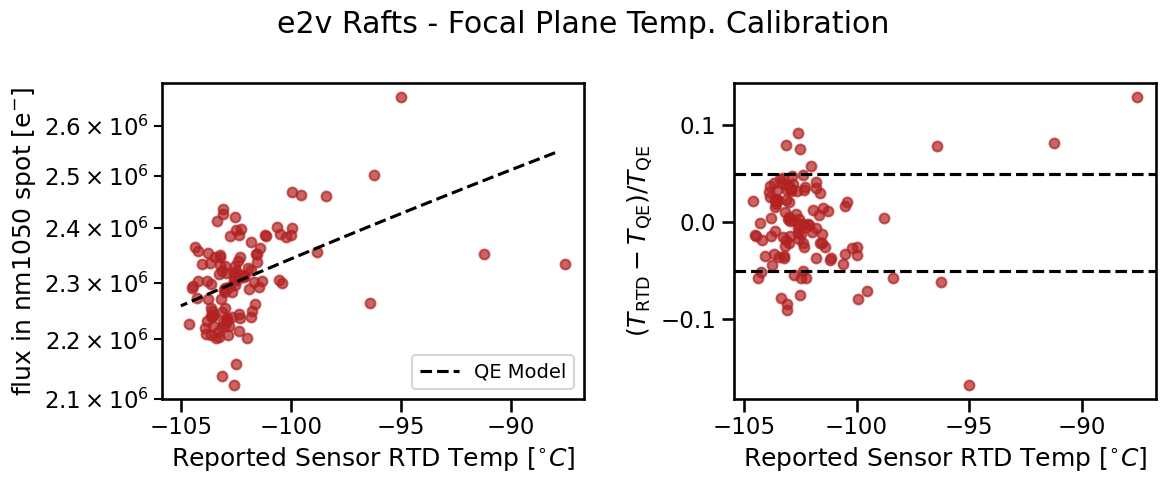

In [101]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
x = np.linspace(-88, -105, 100)
plt.plot(x, linear(x, *pars), color='k', ls='--',label='QE Model')
plt.scatter(df['T(C)'][e2vFlag], df[flux_col][e2vFlag], color='firebrick', s=50, alpha=0.7)

plt.legend(fontsize=14, loc=4)
plt.yscale('log')
plt.xlabel('Reported Sensor RTD Temp [$^{\circ}C$]')
plt.ylabel('flux in %s spot [e$^{-}$]'%flux_col)

plt.subplot(1,2,2)
plt.scatter(rtd, frac_res, color='firebrick', s=50, alpha=0.7)
plt.axhline(-0.05, color='k', ls='--')
plt.axhline(+0.05, color='k', ls='--')
plt.ylabel(r'$(T_{\rm RTD}-T_{\rm QE})/T_{\rm QE}$')
plt.xlabel('Reported Sensor RTD Temp [$^{\circ}C$]')

plt.suptitle('e2v Rafts - Focal Plane Temp. Calibration')
plt.tight_layout()

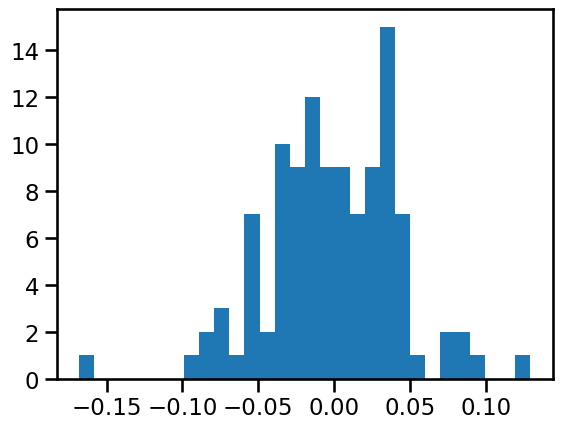

In [82]:
_ = plt.hist(frac_res, bins=30)

Text(0.5, 0, 'Reported Sensor RTD Temp [$^{\\circ}C$]')

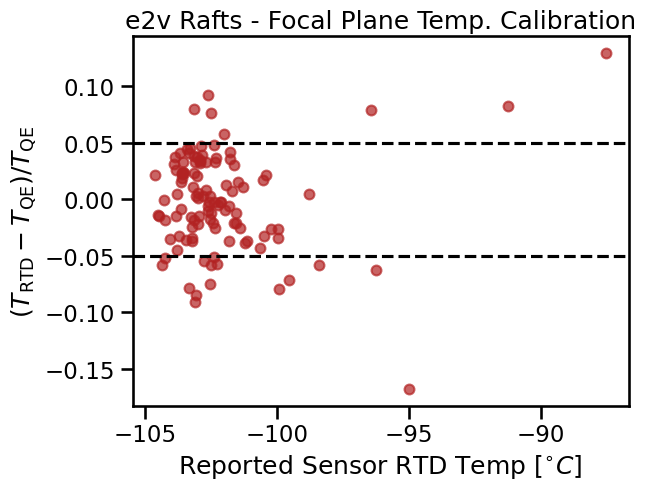

In [83]:
plt.scatter(rtd, frac_res, color='firebrick', s=50, alpha=0.7)
plt.axhline(-0.05, color='k', ls='--')
plt.axhline(+0.05, color='k', ls='--')
plt.title('e2v Rafts - Focal Plane Temp. Calibration')
plt.ylabel(r'$(T_{\rm RTD}-T_{\rm QE})/T_{\rm QE}$')
plt.xlabel('Reported Sensor RTD Temp [$^{\circ}C$]')

In [84]:
df['frac_res'] = np.nan
df['frac_res'][e2vFlag] = frac_res
# df['frac_res'][e2vFlag] = np.where(np.abs(frac_res)<0.1, frac_res, np.nan)

/var/folders/6w/mvq682kn30zd7qxmn0lmt4q00000gs/T/ipykernel_15896/1167986784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['frac_res'][e2vFlag] = frac_res


In [95]:
outliers = df[np.abs(df['frac_res'])>0.08]
outliers

,sensor,Yccs,Xccs,nm1020,nm1050,nm1050/nm1020,T(C),rms_T(C),E2V,frac_res,SXX,RXX
5,R11_S11,2415.500,2492.500,9.507305e+06,2.435859e+06,0.256209,-103.091,0.46739,True,-0.090590,S11,R11
34,R21_S21,2415.500,4608.125,9.438930e+06,2.352982e+06,0.249285,-91.243,0.33921,True,0.082248,S21,R21
55,R23_S02,6118.625,3551.875,8.801926e+06,2.123109e+06,0.241210,-102.607,0.39980,True,0.091892,S02,R23
76,R11_S20,1887.375,3020.625,9.637310e+06,2.427342e+06,0.251869,-103.076,0.36985,True,-0.084663,S20,R11
117,R21_S00,1887.375,3551.875,9.466249e+06,2.334223e+06,0.246584,-87.554,0.41956,True,0.129054,S00,R21
119,R12_S22,4531.125,3020.625,1.006586e+07,2.659351e+06,0.264195,-95.000,0.40474,True,-0.168016,S22,R12


## Calibration Inside A Raft

In [71]:
# Group the DataFrame by 'Sensor'
grouped = df[e2vFlag].groupby('RXX')

# Calculate the sum of values for each sensor group
p1 = grouped['frac_res'].quantile(.16).values
p3 = grouped['frac_res'].quantile(.84).values
mean = grouped['frac_res'].median()

p1 = mean.values-p1
p3 = p3-mean.values
# print(mean_values)

Text(0, 0.5, '$(T_{\\rm RTD}-T_{\\rm QE})/T_{\\rm QE}$')

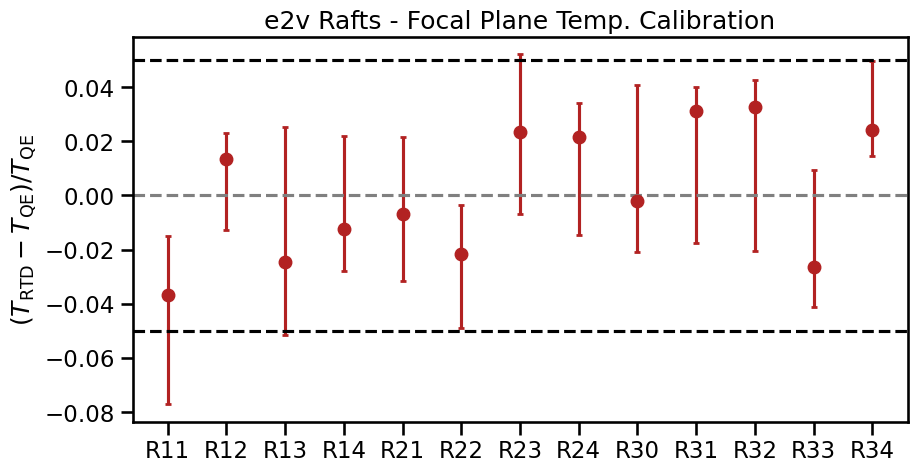

In [72]:
plt.figure(figsize=(10,5))
# plt.scatter(mean.index, mean.values, color='firebrick')
plt.errorbar(mean.index, mean.values, yerr=(p1,p3), fmt='o', capsize=2, capthick=2, color='firebrick')
plt.axhline(0., color='gray', ls='--')
plt.axhline(-0.05, color='k', ls='--')
plt.axhline(+0.05, color='k', ls='--')
# plt.ylim(-0.1,.1)
plt.title('e2v Rafts - Focal Plane Temp. Calibration')
plt.ylabel(r'$(T_{\rm RTD}-T_{\rm QE})/T_{\rm QE}$')



## Calibration Inside A Sensor

In [73]:
# Group the DataFrame by 'Sensor'
grouped = df[e2vFlag].groupby('SXX')

# Calculate the sum of values for each sensor group
p1 = grouped['frac_res'].quantile(.16).values
p3 = grouped['frac_res'].quantile(.84).values
mean = grouped['frac_res'].median()

p1 = mean.values-p1
p3 = p3-mean.values
# print(mean_values)

Text(0, 0.5, '$(T_{\\rm RTD}-T_{\\rm QE})/T_{\\rm QE}$')

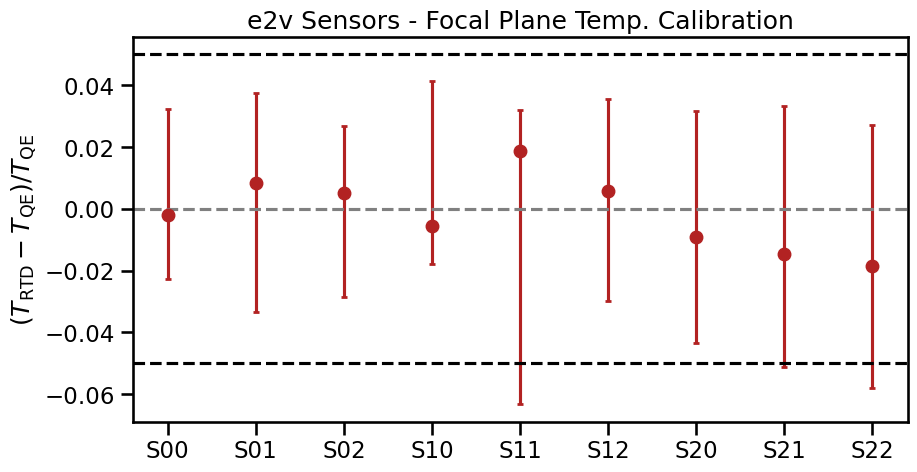

In [74]:
plt.figure(figsize=(10,5))
# plt.scatter(mean.index, mean.values, color='firebrick')
plt.errorbar(mean.index, mean.values, yerr=(p1,p3), fmt='o', capsize=2, capthick=2, color='firebrick')
plt.axhline(0., color='gray', ls='--')
plt.axhline(-0.05, color='k', ls='--')
plt.axhline(+0.05, color='k', ls='--')
# plt.ylim(-0.1,.1)
plt.title('e2v Sensors - Focal Plane Temp. Calibration')
plt.ylabel(r'$(T_{\rm RTD}-T_{\rm QE})/T_{\rm QE}$')



## QE Ratio

In [146]:
flux_col = 'nm1050/nm1020'

In [199]:
flag = np.array(e2vFlag)
ix_out = np.where((df[flux_col]<0.255)& (df['T(C)']>-97.))[0]
outline_sensors = list(df['sensor'].iloc[ix_out].to_numpy())
flag[ix_out] = False
outline_sensors

['R21_S21', 'R34_S01', 'R21_S00']

In [200]:
linear2 = lambda x, a, b: a*x + b
pars, pcov = curve_fit(linear2, df['T(C)'][flag], np.log(df[flux_col][flag]))
pars

array([ 0.00707718, -0.67239028])

In [201]:
from scipy.interpolate import interp1d

x = np.linspace(-10, -200, 1000)
rtd = df['T(C)'].to_numpy()
flux = df[flux_col].to_numpy()

qe_temp = interp1d(linear2(x, *pars), x)(np.log(flux))

res = qe_temp-rtd
frac_res = res/qe_temp

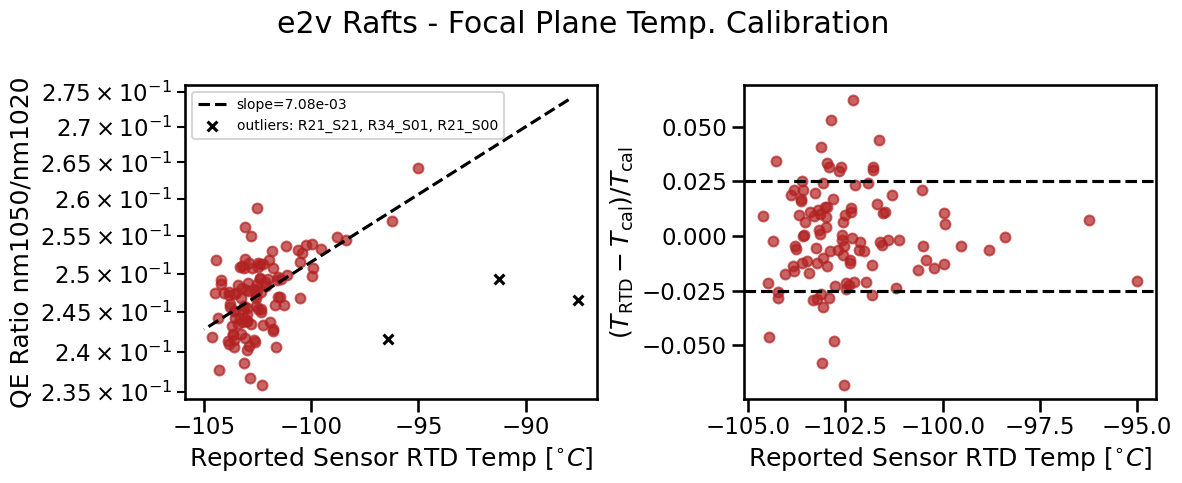

In [205]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
x = np.linspace(-88, -105, 100)
plt.plot(x, np.exp(linear2(x, *pars)), color='k', ls='--',label='slope=%.2e'%pars[0])
plt.scatter(df['T(C)'][flag], df[flux_col][flag], color='firebrick', s=50, alpha=0.7)
plt.scatter(df['T(C)'].iloc[ix_out], df[flux_col].iloc[ix_out], color='k', marker='x', s=50, label='outliers: %s'%((', ').join(outline_sensors)))

plt.legend(fontsize=10, loc=0)
plt.yscale('log')
plt.xlabel('Reported Sensor RTD Temp [$^{\circ}C$]')
plt.ylabel('QE Ratio %s'%flux_col)

plt.subplot(1,2,2)
plt.scatter(rtd[flag], frac_res[flag], color='firebrick', s=50, alpha=0.7)
plt.axhline(-0.025, color='k', ls='--')
plt.axhline(+0.025, color='k', ls='--')
plt.ylabel(r'$(T_{\rm RTD}-T_{\rm cal})/T_{\rm cal}$')
plt.xlabel('Reported Sensor RTD Temp [$^{\circ}C$]')

plt.suptitle('e2v Rafts - Focal Plane Temp. Calibration')
plt.tight_layout()
plt.savefig('qe_ratio_rtd_temp_fit.png', dpi=150)

## Calibration Inside A Raft

In [203]:
df['frac_res'] = frac_res

# Group the DataFrame by 'Sensor'
grouped = df[flag].groupby('RXX')

# Calculate the sum of values for each sensor group
p1 = grouped['frac_res'].quantile(.16).values
p3 = grouped['frac_res'].quantile(.84).values
mean = grouped['frac_res'].median()

p1 = mean.values-p1
p3 = p3-mean.values
# print(mean_values)

Text(0, 0.5, '$(T_{\\rm RTD}-T_{\\rm cal})/T_{\\rm cal}$')

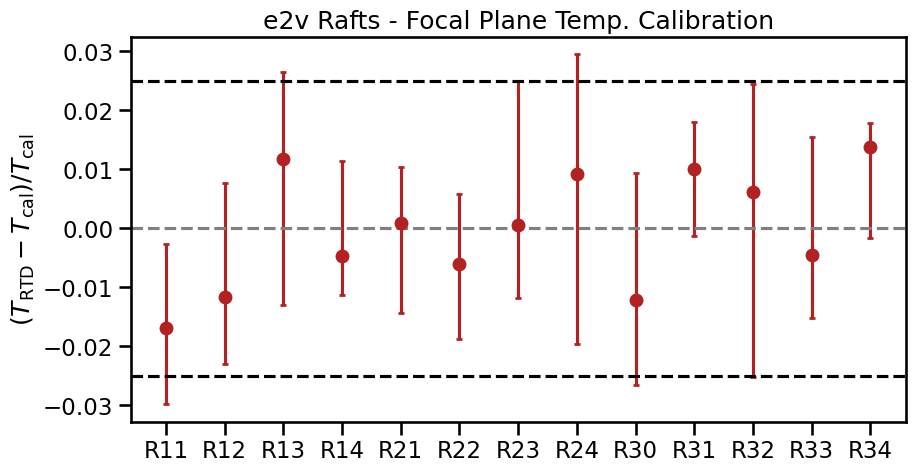

In [204]:
plt.figure(figsize=(10,5))
# plt.scatter(mean.index, mean.values, color='firebrick')
plt.errorbar(mean.index, mean.values, yerr=(p1,p3), fmt='o', capsize=2, capthick=2, color='firebrick')
plt.axhline(0., color='gray', ls='--')
plt.axhline(-0.025, color='k', ls='--')
plt.axhline(+0.025, color='k', ls='--')
# plt.ylim(-0.1,.1)
plt.title('e2v Rafts - Focal Plane Temp. Calibration')
plt.ylabel(r'$(T_{\rm RTD}-T_{\rm cal})/T_{\rm cal}$')



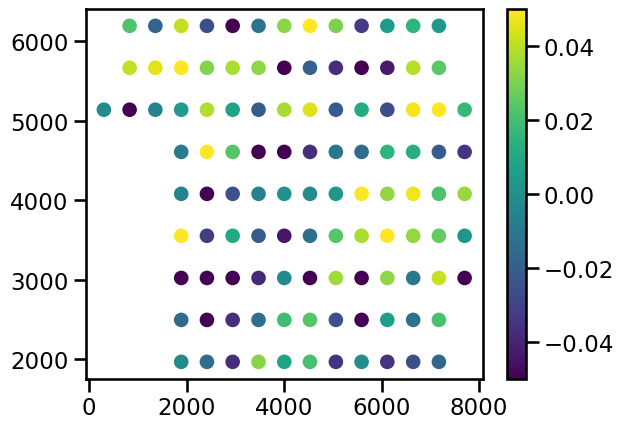

In [13]:
plt.scatter(df.Yccs, df.Xccs, c=df.frac_res, vmin=-0.05, vmax=0.05)
plt.colorbar()

In [ ]:
df['sensor'] = df['channel'].apply(lambda x: x.split('/')[3])

In [90]:
datas2 = []
fnameBadRaft = path+'/ccsTemp/bad-sensors-%s.csv'
for raft in e2vRaftList:
    fname = fnameBadRaft%raft
    _df = pd.read_csv(fname)
    _df['sensor-only'] = _df['Sensor'].apply(lambda x: x.split('-')[1])
    datas2.append(_df)

df2 = pd.concat(datas2).reset_index()

In [97]:
df2[df2.Offset>4.]

,index,Raft,Sensor,Tmean,Tstd,Offset,sensor-only
1,0,R12,R12-S22,-102.883447,0.922887,7.813364,S22
8,0,R21,R21-S00,-102.964423,0.694578,15.424029,S00
9,1,R21,R21-S21,-102.964423,0.694578,11.714886,S21
19,0,R31,R31-S22,-102.969325,0.969114,4.549075,S22
24,0,R33,R33-S11,-101.229875,0.700684,4.818842,S11
26,0,R34,R34-S01,-102.658215,1.135164,6.218685,S01
